In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm
import scipy
import pandas as pd
import datetime

import lightgbm as lg

from collections import OrderedDict    # For recording the model specification 

import statsmodels.tools.numdiff as numdiff       # For numeric hessian
import scipy.linalg                    # For matrix inversion
from statsmodels.stats.descriptivestats import describe

import pylogit as pl                   # For choice model estimation
from pylogit import nested_logit as nl # For nested logit convenience funcs
from xlogit import MixedLogit, MultinomialLogit
import lightgbm as lgb
import catboost

from sklearn.preprocessing import binarize

import pickle
import json

In [2]:
df = pd.read_csv("data/newdata2122.csv", index_col=0)
df["classement"] = df["classement"].replace(['DA', 'NP', '0', 'A ', 'G ', 'D4', 'D3', 'R8', 'D5', 'D2', 'D8', 'D7', 'H8', 'D1', 'D6',
       'D9', 'G4', 'T ', 'G3', 'D ', 'G7', 'G2'], 10).astype(int)
df.head()

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (104,126,127,128,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,nom,numPmu,age,sexe,race,statut,oeilleres,proprietaire,entraineur,driver,...,recordAbs,gain,ecurie,poidsConditionMonte,placeCorde,tauxReclamation,nomPereMere,avisEntraineur,commentaireApresCourse_texte,commentaireApresCourse_source
0,GAZELLE DE VAL,1,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,E. LAMBERTZ,E. LAMBERTZ,https://www.letrot.com/stats/fiche-homme/e-lam...,...,1.154995,40840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GALATA,2,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Y. FAUCHEUX,D. CHERBONNEL,https://www.letrot.com/stats/fiche-homme/d-che...,...,1.014996,43360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GREEN TOWER,3,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Ecurie des CHARMES,J.P. THOMAIN,https://www.letrot.com/stats/fiche-homme/f-lag...,...,-1.504994,46200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,GAULE ROMAINE,4,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Mme M.CL. GUIBOUT,X. GUIBOUT,https://www.letrot.com/stats/fiche-homme/jp-ma...,...,1.294995,48500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GUECHA GIRL,5,5,FEMELLES,TROTTEUR FRANCAIS,PARTANT,SANS_OEILLERES,Y. DREUX,Y. DREUX,https://www.letrot.com/stats/fiche-homme/y-dre...,...,-1.084995,49740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
sorted(list(df))

['acceleration_500m',
 'age',
 'allure',
 'avisEntraineur',
 'avisTrainer',
 'changementCategorie',
 'classement',
 'commentaireApresCourse_source',
 'commentaireApresCourse_texte',
 'date',
 'deferre',
 'dernierRapportDirect_dateRapport',
 'dernierRapportDirect_favoris',
 'dernierRapportDirect_grossePrise',
 'dernierRapportDirect_indicateurTendance',
 'dernierRapportDirect_nombreIndicateurTendance',
 'dernierRapportDirect_numPmu1',
 'dernierRapportDirect_permutation',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_typeRapport',
 'dernierRapportReference_dateRapport',
 'dernierRapportReference_favoris',
 'dernierRapportReference_grossePrise',
 'dernierRapportReference_indicateurTendance',
 'dernierRapportReference_nombreIndicateurTendance',
 'dernierRapportReference_numPmu1',
 'dernierRapportReference_permutation',
 'dernierRapportReference_rapport',
 'dernierRapportReference_typePari',
 'dernierRapportReference_typeRapport',
 'dist',
 'distTo

In [3]:
feat = df.loc[:]

feat["lifepercwin"] = feat["nombreVictoires"] / feat["nombreCourses"]
feat["winPrace"] = feat["gainsParticipant_gainsCarriere"] / feat["nombreCourses"]
feat["newDist"] = abs(feat["last_race_dist"] - feat["dist"]) > 150

feat["publicProbaOfWinning"] = np.exp(1 / feat["dernierRapportDirect_rapport"])
feat["gainDifAnnePrec"] = feat["gainsParticipant_gainsAnneeEnCours"] / feat["gainsParticipant_gainsAnneePrecedente"]

feat.fillna(0,inplace=True)

feat.replace([np.inf, -np.inf], 0, inplace=True)

feat["bonne_reussite_hippo"] = binarize(feat["txReussiteHippo"].to_numpy().reshape(-1, 1),threshold=0.5)
feat["bonne_reussite_couple"] = binarize(feat["txReussiteCouple"].to_numpy().reshape(-1, 1),threshold=0.5)

feat["less_dist_than_last_race"] = (feat["last_race_dist"] > feat["dist"]).astype(int)
feat["dernierRapportReference_favoris"] = feat["dernierRapportReference_favoris"].astype(int)
feat["place_last_race"] = ((feat["lastPerf"] <= 3) & (feat["lastPerf"] >= 1)).astype(int)

feat["remontada"] = binarize(feat["gain_classement_fin"].to_numpy().reshape(-1, 1),threshold=0.25)
feat["avisTrainer"] = feat["avisTrainer"] - 2
feat["lessThanPreferedDist"] = binarize(feat["prefered_dist"].to_numpy().reshape(-1, 1),threshold=0)

feat["lastTimeToRecord"] = np.exp(feat["tpsLastRace"] - feat["recordAbs"])

feat["win"] = feat["classement"] == 1

feat["available"] = 1

feat["classement"] = feat["classement"].replace(0,10)
feat["win"] = feat["win"].replace(False,0)
feat["win"] = feat["win"].replace(True,1)


feat["newDist"] = feat["newDist"].astype(int)

feat.replace([np.inf, -np.inf], np.nan, inplace=True)

feat = feat.set_index(["id", df.groupby("id").cumcount()])
index = pd.MultiIndex.from_product(feat.index.levels, names=feat.index.names)
feat = feat.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()

nindex = len(df.groupby("id")) * list(range(1,feat.groupby("id").cumcount().max()+2))

feat = feat.assign(num=nindex)

feat = feat.groupby("id").filter(lambda x: x.win.sum() == 1)
feat["chid"] = feat["id"].astype(str) + "_1"

feat["classement"].replace(0, 10, inplace=True)

In [4]:
multiindex = [[],[]]

for i in feat.id.unique():
    for j in range(1,22):
        multiindex[0].append(i)
        multiindex[1].append(j)

In [5]:
# feat = feat.set_index(["id", df.groupby("id").cumcount()])
# test_index = pd.MultiIndex.from_arrays(multiindex, names=["id", "num"])
# feat = feat.reindex(test_index, fill_value=0).reset_index(level=1, drop=True).reset_index()

# nindex = len(df.groupby("id")) * list(range(1,feat.groupby("id").cumcount().max()+2))

# feat = feat.assign(num=nindex)
# feat[["id", "num","nom"]].head(25)

In [74]:
n_explo = 1

nfeat = feat.iloc[:18*(len(feat.groupby("id"))//2)].copy()

train = nfeat.copy()
print(len(train.groupby("chid")))
for i in range(2,n_explo+2):
    cfeat = nfeat.copy()

    cfeat["win"] = 0
    cfeat.loc[cfeat["classement"].isin( list(range(1,i)) ), ~cfeat.columns.isin(["id","num","classement"])] = 0
    cfeat.loc[cfeat["classement"].isin( list(range(1,i)) ),"classement"] = 10
    cfeat.loc[cfeat["classement"] == i, "win"] = 1
    cfeat["classement"] = cfeat["classement"] - 1
    cfeat.loc[cfeat["nom"] == 0, "classement"] = 10
    cfeat["chid"] = cfeat["id"].astype(str) + f"_{i}"
    
    train = pd.concat([train, cfeat])
    print(len(train.groupby("chid")))
train = train.sort_values(by=["id", "chid", "num"])

1424
2848


In [75]:
n_course = len(nfeat.groupby("id"))

# train = nfeat.loc[:].iloc[:18 * ( 2 * len(nfeat.groupby("chid"))//3)]
train = train.groupby("chid").filter(lambda x: x.win.sum() == 1)
test = feat.loc[:].iloc[18 * (len(feat.groupby("id")) // 2):]

In [368]:
set(list(feat)) - set(features)

{'allure',
 'available',
 'avisEntraineur',
 'avisTrainer',
 'chid',
 'classement',
 'date',
 'deferre',
 'dernierRapportDirect_dateRapport',
 'dernierRapportDirect_favoris',
 'dernierRapportDirect_grossePrise',
 'dernierRapportDirect_indicateurTendance',
 'dernierRapportDirect_nombreIndicateurTendance',
 'dernierRapportDirect_numPmu1',
 'dernierRapportDirect_permutation',
 'dernierRapportDirect_rapport',
 'dernierRapportDirect_typePari',
 'dernierRapportDirect_typeRapport',
 'dernierRapportReference_dateRapport',
 'dernierRapportReference_favoris',
 'dernierRapportReference_grossePrise',
 'dernierRapportReference_indicateurTendance',
 'dernierRapportReference_nombreIndicateurTendance',
 'dernierRapportReference_numPmu1',
 'dernierRapportReference_permutation',
 'dernierRapportReference_rapport',
 'dernierRapportReference_typePari',
 'dernierRapportReference_typeRapport',
 'driver',
 'driverChange',
 'ecurie',
 'eleveur',
 'engagement',
 'entraineur',
 'gain',
 'gain_classement_fin',
 

In [13]:
ranker = pickle.load(open('models/rankerv1.pickle', 'rb'))
catboostranker = pickle.load(open('models/catboostranker.pickle', 'rb'))

In [14]:
model = MultinomialLogit()
# model = pickle.load(open('models/cl_v1.pickle', 'rb'))

In [15]:
features = ['pc_autre_driver',
 'pc_autre_trainer',
 'pc_dai_driver',
 'pc_dai_trainer',
 'pc_place_driver',
 'pc_place_trainer',
 'pc_victoires_driver',
 'pc_victoires_trainer', 
 'median_reduc_driver',
 'median_reduc_trainer',
 'gains_gagnant_ratio_driver',
 'gains_gagnant_ratio_horse',
 'gains_gagnant_ratio_trainer',
 'gains_place_ratio_driver',
 'gains_place_ratio_horse',
 'gains_place_ratio_trainer','10_mean_reduc_horse',
 '20_mean_reduc_driver',
 '20_mean_reduc_trainer',
 '50_mean_reduc_driver',
 '50_mean_reduc_trainer','nbVictoiresCouple','lifepercwin','meanPerf',
 'medianPerf',
 'modePerf','bonne_reussite_couple',
 'bonne_reussite_hippo','progressTps','prefered_dist_driver','moreFirstThanThirdCouple','gainDifAnnePrec','recordAbs','acceleration_500m','less_dist_than_last_race',
            "place_last_race", 'last_race_dist','tpsLastRace','timeSinceRecord',
 'minReduction','medianReduction','meanReduction','changementCategorie','distToPreferedDist','prefered_dist','jockeyHabitude',
 'nbDiscalifieMusic','nbVictoireMusic','nbPlaceMusic',
 'fer','gainsParticipant_gainsCarriere','sex','age','dist', 'firstTimeFer',
 'formePlace','formeVictoire','lastPerf','mean_dist_arrivee','nbVictoiresHippo','nombreCourses','nbCourseHippo',
 'txVictoireCouple','txVictoireHippo']

features_bac = ["fer","maxReduction_z","num","meanReduction_z","medianPerf_z","medianReduction_z","nbVictoiresTrainer_z","modePerf_z","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs_z","nbDiscalifieMusic_z","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
# features = ["fer","nbDiscalifieMusic","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","nombrePlacesSecond","nombrePlacesTroisieme_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]


# randvars = {name:"n" for name in features}
randvars={"nbDiscalifieMusic":"u"}

In [437]:
reduc_filt = train.loc[(train["reductionKilometrique"] != np.nan) & (train["reductionKilometrique"] > 0.0)]
# regressor = lg.LGBMRegressor()
# regressor.fit(reduc_filt[features], y=reduc_filt["reductionKilometrique"])

from sklearn import linear_model
regr = linear_model.Lasso(alpha=0.1)
regr.fit(reduc_filt[catboostranker.feature_names_].to_numpy().reshape(-1,len(catboostranker.feature_names_)),reduc_filt["reductionKilometrique"].to_numpy())

Lasso(alpha=0.1)

In [418]:
len(features)

36

In [12]:
catboostranker = catboost.CatBoostRanker()
catboostranker.fit(train[catboostranker.feature_names_],y=train["classement"],group_id=train["chid"], verbose=None)

KeyError: None

In [76]:
catpredict = catboostranker.predict(test[catboostranker.feature_names_],verbose=None)

train["rank_pred_cat"] = catboostranker.predict(train[catboostranker.feature_names_],verbose=None)

test["rank_pred_cat"] = catpredict
# test['rank_pred'] = test.groupby("chid")["rank_pred_cat"].rank("dense",ascending=True).astype(int)
# test['rank_pred'] = test.groupby("chid")["rank_pred_cat"].rank("first").astype(int)

In [387]:
ranker = lg.LGBMRanker(boosting_type="dart",n_estimators=1000,num_leaves=100, min_data_in_bin=50,max_bin=500,reg_alpha=0.01,metric="ndcg")
groups = train.groupby('chid').size().to_frame('size')['size'].to_numpy()
groups_test = test.groupby('chid').size().to_frame('size')['size'].to_numpy()

ranker.fit(train[features], y=train["classement"],eval_set=[(test[features], test["classement"])],
           eval_group=[groups_test],eval_metric="ndcg", group=groups,verbose=1000)

[1000]	valid_0's ndcg@1: 0.99483	valid_0's ndcg@2: 0.994163	valid_0's ndcg@3: 0.983036	valid_0's ndcg@4: 0.966748	valid_0's ndcg@5: 0.944101


LGBMRanker(boosting_type='dart', max_bin=500, metric='ndcg', min_data_in_bin=50,
           n_estimators=1000, num_leaves=100, reg_alpha=0.01)

In [112]:
pickle.dump(second_model, open("models/second_model2.pickle", "wb"))

In [438]:
train_speed_pred = regr.predict(train[catboostranker.feature_names_].to_numpy().reshape(-1,len(catboostranker.feature_names_)))
train["speed_pred"] = train_speed_pred

test_speed_pred = regr.predict(test[catboostranker.feature_names_].to_numpy().reshape(-1,len(catboostranker.feature_names_)))
test["speed_pred"] = test_speed_pred

In [77]:
train_rank_pred = ranker.predict(train[ranker.feature_name_])
train["rank_pred"] = train_rank_pred

rank_pred = ranker.predict(test[ranker.feature_name_])
test["rank_pred"] = rank_pred
# test['rank_pred'] = test.groupby("chid")["rank_pred"].rank("dense",ascending=True).astype(int)
# test['rank_pred'] = test.groupby("chid")["rank_pred"].rank("first").astype(int)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

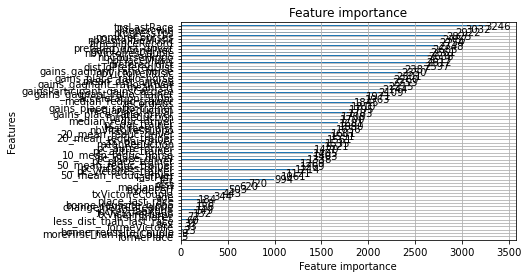

In [389]:
lgb.plot_importance(ranker)

In [24]:
test["rank_pred_proba"] = np.exp(test["rank_pred"]) / test.groupby("chid")["rank_pred"].transform(lambda x: sum(np.exp(x)))
train["rank_pred_proba"] = np.exp(train["rank_pred"]) / train.groupby("chid")["rank_pred"].transform(lambda x: sum(np.exp(x)))

In [26]:
train["rank_pred_proba"].sum()

1424.0

In [441]:
sum(test[test["win"] == 1]["rank_pred"] == 1) / len(test[test["win"] == 1])

0.0

In [419]:
model.fit(X = train[features], y = train["win"], varnames=features, ids=train["chid"],alts=train["num"],avail=train["available"],maxiter=10000,tol_opts={"gtol": 1e-10})
model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 17
    Function evaluations: 19
Estimation time= 0.5 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
progressTps             0.1210084     0.1958774     0.6177761         0.659    
prefered_dist_drive    -0.0833872     0.0576982    -1.4452319         0.281    
moreFirstThanThirdC     0.2122283     0.2204649     0.9626401         0.501    
gainDifAnnePrec         0.0000453     0.0003342     0.1355729          0.79    
recordAbs              -0.1383177     0.2076492    -0.6661127         0.638    
acceleration_500m       0.0071677     0.0048900     1.4657968         0.272    
less_dist_than_last    -0.1250192     0.1860316    -0.6720319         0.636    
place_last_race         0.4429675     0.1345459     

In [18]:
choice_estimate, proba_estimate = model.predict(X=train[features], varnames=features, ids=train["chid"], alts=train["num"],avail=train["available"],return_proba=True)
train["probaModel"] = proba_estimate.flatten()
train["probaModel"].replace(-np.inf,0, inplace=True)
train["probaModel"].fillna(0, inplace=True)

choice_estimate, proba_estimate = model.predict(X=test[features], varnames=features, ids=test["chid"], alts=test["num"],avail=test["available"],return_proba=True)
test["probaModel"] = proba_estimate.flatten()
test["probaModel"].replace(-np.inf,0, inplace=True)
test["probaModel"].fillna(0, inplace=True)

KeyError: "['gains_gagnant_ratio_driver', 'median_reduc_trainer', 'pc_dai_trainer', '20_mean_reduc_driver', 'gains_place_ratio_driver', 'pc_dai_driver', 'pc_victoires_trainer', '50_mean_reduc_driver', 'pc_autre_trainer', 'pc_autre_driver', 'gains_place_ratio_trainer', 'pc_place_trainer', '20_mean_reduc_trainer', '50_mean_reduc_trainer', 'gains_place_ratio_horse', 'median_reduc_driver', 'gains_gagnant_ratio_trainer', 'pc_place_driver', '10_mean_reduc_horse', 'pc_victoires_driver', 'gains_gagnant_ratio_horse'] not in index"

In [78]:
null_model = MultinomialLogit()
null_model.fit(X=train[["publicProbaOfWinning"]], y=train["win"], varnames=["publicProbaOfWinning"], ids=train["chid"],alts=train["num"],avail=train["available"])
null_model.summary()
# null_choice, null_proba = null_model.predict(X=test[["publicProbaOfWinning"]], varnames=["publicProbaOfWinning"], ids=test["id"], alts=test["num"], return_proba=True)

# accu = np.sum(winners == null_choice)/len(null_choice)
# print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 6
    Function evaluations: 7
Estimation time= 0.0 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
publicProbaOfWinnin     4.3210540     0.1028206    42.0251908     2.92e-299 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -6158.704
AIC= 12319.409
BIC= 12325.362


In [80]:
# second_model = pickle.load(open('models/cl_v2.pickle', 'rb'))



train["mean_rank"] = np.exp(0.1*train["rank_pred"] + 0.9*train["rank_pred_cat"])
test["mean_rank"] = np.exp(0.1*test["rank_pred"] + 0.9*test["rank_pred_cat"])

# test["rank_pred_proba"] = np.exp(test["rank_pred"]) / test.groupby("chid")["rank_pred"].transform(lambda x: sum(np.exp(x)))
# train["rank_pred_proba"] = np.exp(train["rank_pred"]) / train.groupby("chid")["rank_pred"].transform(lambda x: sum(np.exp(x)))

# test["rank_pred_cat_proba"] = np.exp(test["rank_pred_cat"]) / test.groupby("chid")["rank_pred_cat"].transform(lambda x: sum(np.exp(x)))
# train["rank_pred_cat_proba"] = np.exp(train["rank_pred_cat"]) / train.groupby("chid")["rank_pred_cat"].transform(lambda x: sum(np.exp(x)))

varnames = ["publicProbaOfWinning","mean_rank"]

second_model = MultinomialLogit()
second_model.fit(X=train[varnames],y=train["win"],varnames=varnames, ids=train["chid"],alts=train["num"],avail=train["available"])
second_model.summary()

Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 11
    Function evaluations: 12
Estimation time= 0.1 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
publicProbaOfWinnin     1.7491624     0.1161165    15.0638564         3e-48 ***
mean_rank             -13.4322495     0.3982166   -33.7310131      9.9e-209 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -4980.906
AIC= 9965.811
BIC= 9977.718


In [114]:
choice, proba = second_model.predict(X=test[varnames],varnames=varnames, ids=test["id"],alts=test["num"],avail=test["available"], return_proba=True)

winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()
winners = test.loc[test["win"] == 1]["num"].to_numpy()

odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

def kelly(p,b):
    return (p-(1/b))/(1-1/b)

def expe(p,b):
    e = p*(b+1)
    m_e = np.argmax( e )
    return m_e, e[m_e]

accu = np.sum(winners == choice)/len(choice)
print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Win%: 30.130000000000003%, nbet: 1424


In [115]:
proba[0]

array([0.01349046, 0.08809422, 0.0661346 , 0.00098957, 0.00184416,
       0.00973886, 0.16982731, 0.10419767, 0.10028198, 0.37787606,
       0.00962401, 0.0579011 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [116]:
# classifier = lg.LGBMClassifier()
# classifier.fit(train[["publicProbaOfWinning", "rank_pred_proba"]], y=train["win"])

In [117]:
test["proba"] = proba.flatten()

In [118]:
nb_chevaux = []
proba_moy_theo = []
proba_moy = []
rapport_moyen = []
classe = [0,0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.4,1.]
inter = []
prob_real = []
for i,j in zip(classe, classe[1:]):
    inter.append(f"{i} à {j}")
    echantillon = proba.flatten()[(i < proba.flatten()) & (proba.flatten() <= j)]
    
    prob_r = len(test[(i < test["proba"] ) & (test["proba"] <=j ) & (test["win"] == 1)]) / len(test[(i < test["proba"] ) & (test["proba"] <=j )])
    prob_real.append(prob_r)
    
    rapport = test[(i < test["proba"] ) & (test["proba"] <=j ) & (test["win"] == 1 )]["dernierRapportDirect_rapport"].to_numpy()
    rapport_moyen.append(np.mean(rapport))
    nb_chevaux.append( len(echantillon ))
    proba_moy.append( np.mean(echantillon) )
    proba_moy_theo.append(np.mean([i,j]))
rapport_moy_theo = 1/np.array(proba_moy_theo)

In [119]:
pd.DataFrame({"PROBA": inter, "Proba moyenne théorique": proba_moy_theo, "Rapport théorique": rapport_moy_theo, "Proba moyenne": proba_moy,"Proba Reelle":prob_real,"Rapport moyen": rapport_moyen, "NB Chevaux": nb_chevaux})

,PROBA,Proba moyenne théorique,Rapport théorique,Proba moyenne,Proba Reelle,Rapport moyen,NB Chevaux
0,0 à 0.01,0.0050,200.000000,0.002581,0.019018,31.698095,5521
1,0.01 à 0.025,0.0175,57.142857,0.016941,0.034942,18.897619,2404
2,0.025 à 0.05,0.0375,26.666667,0.036626,0.045807,15.832203,2576
3,0.05 à 0.1,0.0750,13.333333,0.073093,0.071471,12.374380,3386
4,0.1 à 0.15,0.1250,8.000000,0.122670,0.102813,10.443396,2062
5,0.15 à 0.2,0.1750,5.714286,0.172227,0.137902,6.411656,1182
6,0.2 à 0.25,0.2250,4.444444,0.222389,0.189802,5.037313,706
7,0.25 à 0.3,0.2750,3.636364,0.272619,0.229167,4.271591,384
8,0.3 à 0.4,0.3500,2.857143,0.342316,0.299252,3.697500,401
9,0.4 à 1.0,0.7000,1.428571,0.528306,0.486154,2.227215,325


In [120]:
accu = np.sum(winners == choice)/len(choice)
print(f"Win%: {round(accu, 4) * 100}%, nbet: {len(choice)}")

Win%: 30.130000000000003%, nbet: 1424


In [211]:
test["date"] = pd.to_datetime(test["date"])

In [61]:
test["date"][test["date"] != "1970-01-01"].min()

Timestamp('2021-01-31 00:00:00')

In [25]:
# with open("data/rapport2.json", "r") as f:
#     rapports = json.load(f)
with open("data/rapport.json", "r") as f:
    rapports = json.load(f)

In [252]:
test[test["rank_pred"] == 1][["id","win"]]

,id,win
25659,2021082414751,0
25675,2021082414752,1
25690,2021082414753,0
25709,2021082414755,0
25726,2021082414756,0
...,...,...
51218,2022121375002,0
51234,2022121375003,0
51249,2022121375005,0
51274,2022121375007,1


      mean    max  min  median
0  8.30536  375.0  1.1     2.2
33.3804143126177% de win, 709
666€ 2124 paris
Max drawdown: -69%


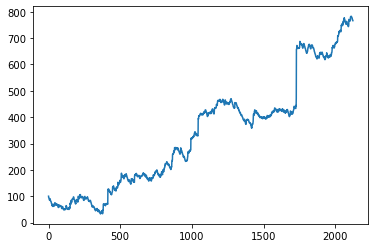

In [111]:
place = []
courses_list = test["id"].unique()

rapport_won = []
evo = [100]
money = 100
wins = 0

pub_prob = test["publicProbaOfWinning"].to_numpy().reshape(-1,18)

won_id = []

gain_place = []
gain_gagnant = []
max_dd = 0

for i in range(len(choice)):
    choice_in_df = test[(test["id"] == courses_list[i]) & (test["num"] == choice[i])].iloc[0]
    sorted_proba = np.argsort(proba[i])
    p = proba[i, sorted_proba[-1]]
    odd = choice_in_df["dernierRapportDirect_rapport"]
    expe = p * odd - (1-p)
    
    proba_jumele = proba[i, sorted_proba[-1]] * (proba[i, sorted_proba[-2]]**(0.76))/ np.sum(np.delete(proba[i],sorted_proba[-1])**(0.76))
    proba_trio = 0    
    proba_jumele_public = pub_prob[i, sorted_proba[-1]] * (pub_prob[i, sorted_proba[-2]]**(0.76))/ np.sum(np.delete(pub_prob[i],sorted_proba[-1])**(0.76))
    proba_trio_public = 0
    proba_jumele += proba[i, sorted_proba[-2]] * (proba[i, sorted_proba[-1]]**(0.76))/ np.sum(np.delete(proba[i],sorted_proba[-2])**(0.76))
    proba_jumele_public += pub_prob[i, sorted_proba[-2]] * (pub_prob[i, sorted_proba[-1]]**(0.76)) / np.sum(np.delete(pub_prob[i],sorted_proba[-2])**(0.76))
# #     print(proba_jumele)
    
    combinaisons_trio = [[1,2,3],[1,3,2],[2,1,3],[2,3,1],[3,2,1],[3,1,2]]
    
    for combi in combinaisons_trio:
        proba_trio += proba[i, sorted_proba[-combi[0]]] * (proba[i, sorted_proba[-combi[1]]]**(0.76)) * (proba[i, sorted_proba[-combi[2]]]**(0.84))/ np.sum(proba[i])**(0.76)
        proba_trio_public += pub_prob[i, sorted_proba[-combi[0]]] * (pub_prob[i, sorted_proba[-combi[1]]]**(0.76)) * (pub_prob[i, sorted_proba[-combi[2]]]**(0.84))/ np.sum(pub_prob[i])**(0.76)

    
#     proba_public += pub_prob[i, sorted_proba[-2]] * (pub_prob[i, sorted_proba[-1]]**(0.76))/ np.sum(np.delete(pub_prob[i],sorted_proba[-2])**(0.76))
    
    bet_size = np.ceil(1 + 0.005*money)
    if str(choice_in_df.id) in rapports:
#         if "E_SIMPLE_PLACE" in rapports[str(choice_in_df.id)]:
#             if True:
#                 frackel = max(1, money * kelly(np.average([p, 1/odd]), odd) /4)
#                 odds = rapports[str(choice_in_df.id)]["E_SIMPLE_PLACE"]["rapports"]
#                 for j in odds:

#                     if all([x in [sorted_proba[-1] + 1] for x in j["combinaison"]]):
# #                         print("GAGNANT",(j["dividendePourUnEuro"] / 100), j["combinaison"],p, odd)

#                         money += frackel*j["dividendePourUnEuro"] / 100
#                         rapport_won.append(j["dividendePourUnEuro"] / 100)
#                         won_id.append(courses_list[i])
#                         wins+=1
#                 money-=frackel
#                 gain_gagnant.append(money-evo[-1])
#                 evo.append(money)
        if "E_SIMPLE_PLACE" in rapports[str(choice_in_df.id)]:
            if p > 0.2:
                odds = rapports[str(choice_in_df.id)]["E_SIMPLE_PLACE"]["rapports"]
                for j in odds:

                    if all([x in [sorted_proba[-1] + 1] for x in j["combinaison"]]):
#                         print("GAGNANT",(j["dividendePourUnEuro"] / 100), j["combinaison"],p, odd)

                        money += 5*j["dividendePourUnEuro"] / 100
                        rapport_won.append(j["dividendePourUnEuro"] / 100)
                        won_id.append(courses_list[i])
                        wins+=1
                money -= 5
                gain_gagnant.append(money-evo[-1])
                evo.append(money)
        if "E_COUPLE_GAGNANT" in rapports[str(choice_in_df.id)]:         
            if True: 
                odds = rapports[str(choice_in_df.id)]["E_COUPLE_GAGNANT"]["rapports"]
                for j in odds:
                    if sorted_proba[-1] + 1 in j["combinaison"] and all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1] for x in j["combinaison"]]):

                        money += 0.1 * j["dividendePourUnEuro"] / 100
                        rapport_won.append(j["dividendePourUnEuro"] / 100)
                        won_id.append(courses_list[i])
#                         print("CP",(j["dividendePourUnEuro"] / 100), j["combinaison"], bet_size * j["dividendePourUnEuro"] / 100)
                        wins+=1
                        

                money-= 0.3
                gain_place.append(money-evo[-1])
                evo.append(money)
                
        if "E_DEUX_SUR_QUATRE" in rapports[str(choice_in_df.id)]:         
            if True: 
                odds = rapports[str(choice_in_df.id)]["E_DEUX_SUR_QUATRE"]["rapports"]
                for j in odds:
                    if all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1] for x in j["combinaison"]]):

                        money += 2*j["dividendePourUnEuro"] / 100
                        rapport_won.append(j["dividendePourUnEuro"] / 100)
                        won_id.append(courses_list[i])
#                         print("2sur4",(j["dividendePourUnEuro"] / 100), j["combinaison"], bet_size * j["dividendePourUnEuro"] / 100)
                        wins+=1
                        

                money -= 2
                gain_place.append(money-evo[-1])
                evo.append(money)
                
        if "E_TRIO" in rapports[str(choice_in_df.id)]:
            if True: 
                odds = rapports[str(choice_in_df.id)]["E_TRIO"]["rapports"]
                for j in odds:
                    if sorted_proba[-1] + 1 in j["combinaison"] and all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1] for x in j["combinaison"]]):

                        money += 0.1 * j["dividendePourUnEuro"] / 100
                        rapport_won.append(j["dividendePourUnEuro"] / 100)
                        won_id.append(courses_list[i])
#                         print("TRIO",(j["dividendePourUnEuro"] / 100), j["combinaison"],[sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1], bet_size * j["dividendePourUnEuro"] / 100)
                        wins+=1
                        break

                money-= 0.3
                gain_place.append(money-evo[-1])
                evo.append(money)
        if "E_MINI_MULTI" in rapports[str(choice_in_df.id)]:
            if True: 
                odds = rapports[str(choice_in_df.id)]["E_MINI_MULTI"]["rapports"]
                for j in odds:
                    if j['libelle'] == 'e-Mini Multi en 4':
                        if sorted_proba[-1] + 1 in j["combinaison"] and all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1,sorted_proba[-5] + 1] for x in j["combinaison"]]):

                            money += 0.5 * j["dividendePourUnEuro"] / 100
                            rapport_won.append(j["dividendePourUnEuro"] / 100)
                            won_id.append(courses_list[i])
#                             print("E_MINI_MULTI",(j["dividendePourUnEuro"] / 100), j["combinaison"],[sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1], bet_size * j["dividendePourUnEuro"] / 100)
                            wins+=1
                            break

                money-= 2
                gain_place.append(money-evo[-1])
                evo.append(money)
#         if "E_PICK5" in rapports[str(choice_in_df.id)]:         
#             if True: 
#                 odds = rapports[str(choice_in_df.id)]["E_PICK5"]["rapports"]
#                 for j in odds:
#                     if all([x in [sorted_proba[-1] + 1,sorted_proba[-2] + 1,sorted_proba[-3] + 1,sorted_proba[-4] + 1,sorted_proba[-5] + 1] for x in j["combinaison"]]):

#                         money += 1 * j["dividendePourUnEuro"] / 100
#                         rapport_won.append(j["dividendePourUnEuro"] / 100)
#                         won_id.append(courses_list[i])
# #                         print("E_PICK5",(j["dividendePourUnEuro"] / 100), j["combinaison"], bet_size * j["dividendePourUnEuro"] / 100)
#                         wins+=1
#                         break

#                 money-=1
#                 gain_place.append(money-evo[-1])
#                 evo.append(money)
    max_dd = min( (money - max(evo)) / max(evo) , max_dd)


rapport_won = np.array(rapport_won)
print(describe(rapport_won, stats=["max", "min", "mean", "median"]).T)
print(f"{wins/len(evo)*100}% de win, {wins}")
print(f"{int(money-evo[0])}€ {len(evo)} paris")
print(f"Max drawdown: {int(max_dd*100)}%")
evo = np.array(evo)
plt.plot(evo)
#plt.title("Simple Placé, 2sur4, Trio, Couplé Placé en misant 0.5% de la bankroll sur chaque paris");

In [466]:
print(len(gain_place),sum(gain_place),"|",len(gain_gagnant),sum(gain_gagnant))
print(min(evo))

1650 515.4300000000023 | 492 169.0
40.07000000000045


In [24]:
test.loc[test["id"] == won_id[0]][["hippo", "num","numCoursePMU", "classement","date","dernierRapportDirect_rapport"]]

KeyError: "['hippo'] not in index"

In [271]:
dquatre = 0
cp = 0
for i in rapports:
    if "E_DEUX_SUR_QUATRE" in rapports[i]:
        dquatre += 1
    if "E_COUPLE_PLACE" in rapports[i]:
        cp += 1
print(dquatre,cp)

5146 5977


In [44]:
test.loc[test["id"] == race_id[2]][["id", "num","numCoursePMU", "classement","date","dernierRapportDirect_rapport"]]

,id,num,numCoursePMU,classement,date,dernierRapportDirect_rapport
26046,2021082943015,1,R8C5,10,2021-08-29,91.0
26047,2021082943015,2,R8C5,9,2021-08-29,31.0
26048,2021082943015,3,R8C5,6,2021-08-29,16.0
26049,2021082943015,4,R8C5,7,2021-08-29,5.6
26050,2021082943015,5,R8C5,5,2021-08-29,27.0
26051,2021082943015,6,R8C5,10,2021-08-29,63.0
26052,2021082943015,7,R8C5,2,2021-08-29,2.4
26053,2021082943015,8,R8C5,8,2021-08-29,9.9
26054,2021082943015,9,R8C5,3,2021-08-29,7.0
26055,2021082943015,10,R8C5,4,2021-08-29,20.0


In [121]:
def recsum(x):
    return sum([i for i in range(x+1)])

   mean   max  min  median
0   5.3  25.0  1.3     3.6
Win%: 0.23789473684210527, nwin: 113,nbet: 475, ncourses: 1424
Gain de 1760€, gain moyen de 0.92%
Max lose streak: 23


<ipython-input-136-ac841a764825>:41: RuntimeWarning: divide by zero encountered in true_divide
  SR = (proba[i, :] - (1/odds[i, :])) / np.sqrt(proba[i, :] * (1-proba[i, :]))


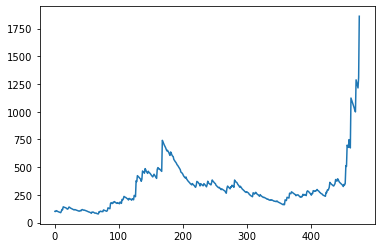

In [136]:
win = 0
tot = 0
odds_winned = []
expe_won = []
proba_won = []

proba_lost = []
odds_lost= []

money = 100
evo = [101,money]

lstreak = 0

max_lstreak = 0

sorted_proba = np.argsort(proba)

race_id = []

bet = []

gain = []

c_1 = 0
c_2 = 0

for i in range(len(choice)):
    cheval,Er = expe(proba[i], odds[i])
#     place_best = sorted_proba[i, -3:]
    
#     best_place,Er = expe(proba[i], odds[i])
#     print(best_place,Er, place_best[best_place])
#     best_expe = place_best[best_place]
    
    er = proba[i, :] * odds[i, :]
    
    er_sorted = np.argsort(er)
    best_espe = er_sorted[-1] + 1 
    
    SR = (proba[i, :] - (1/odds[i, :])) / np.sqrt(proba[i, :] * (1-proba[i, :]))
    
    c = np.argmax(SR)
    
    choice_expe = proba[i, c] * odds[i][c] - (1-proba[i, c])
    schoice_expe = proba[i, sorted_proba[-2]] * odds[i][sorted_proba[-2]]
    
#     b_espe = sorted_proba[-1] if choice_expe > schoice_expe else sorted_proba[-2]
#     max_espe = max(choice_expe,schoice_expe)

#     c = sorted_proba[i,-1]

#     b1=1
    wagger1 =  kelly(np.mean([proba[i][c],1/odds[i][c]]),odds[i][c]) / 5
    if proba[i][c] > 0.2 and wagger1 > 0:
#         wagger2 = kelly(proba[i][sorted_proba[-2]],odds[i][sorted_proba[-2]]) / 3
#         bet_value = min(wagger*money/3, 0.05*money)
#         b1 = max(np.ceil(0.02*money),min(money//2, odds[i][choice[i] - 1]))
        b1 = np.ceil(wagger1 * money)
        if c+1 == winners[i]:
            race_id.append( test["id"].unique()[i] )
            win += 1
#             print(f"Win le {winners[i]} a gagné  avec une cote de {odds[i][c]}, {b1}, {money}")
            money += odds[i][c] * b1
            gain+=[(odds[i][c] * b1)/money]
            odds_winned.append(odds[i][c])
            expe_won.append(choice_expe)
            proba_won.append(proba[i, c])
            lstreak = 0
        else:
            proba_lost.append(proba[i, c])
            odds_lost.append(odds[i, c])
            gain+=[-b1/money]
            lstreak+=1
            
        money -= b1
        
        max_lstreak = max(max_lstreak, lstreak)
        
        bet.append(b1)
        evo.append(money)
        tot+=1
        
print(describe(odds_winned, stats=["max", "min", "mean", "median"]).T)
# print(describe(expe_won, stats=["max", "min", "mean", "median"]).T)
print(f"Win%: {win/tot}, nwin: {win},nbet: {tot}, ncourses: {len(choice)}")
print(f"Gain de {int(money-100)}€, gain moyen de {round(np.mean(gain)*100,2)}%")
print("Max lose streak:", max_lstreak)
plt.plot(evo)
# plt.yscale("log")

In [126]:
evo

[101,
 100,
 102.5,
 102.5,
 101.5,
 100.5,
 99.5,
 99.5,
 98.5,
 97.5,
 100.4,
 106.30000000000001,
 105.30000000000001,
 111.9,
 110.9,
 110.9,
 110.9,
 110.9,
 109.9,
 107.9,
 107.9,
 110.7,
 110.7,
 110.7,
 108.7,
 108.7,
 107.7,
 106.7,
 106.7,
 105.7,
 104.7,
 105.9,
 105.9,
 105.9,
 105.9,
 105.9,
 104.9,
 103.9,
 103.9,
 104.80000000000001,
 104.80000000000001,
 103.80000000000001,
 107.60000000000001,
 108.00000000000001,
 108.00000000000001,
 107.00000000000001,
 107.30000000000001,
 107.30000000000001,
 107.30000000000001,
 107.30000000000001,
 106.30000000000001,
 105.30000000000001,
 105.30000000000001,
 104.30000000000001,
 104.30000000000001,
 103.30000000000001,
 102.30000000000001,
 100.30000000000001,
 100.30000000000001,
 100.30000000000001,
 100.30000000000001,
 99.30000000000001,
 98.30000000000001,
 98.30000000000001,
 98.80000000000001,
 98.80000000000001,
 96.80000000000001,
 96.80000000000001,
 96.80000000000001,
 96.80000000000001,
 96.80000000000001,
 96.8000

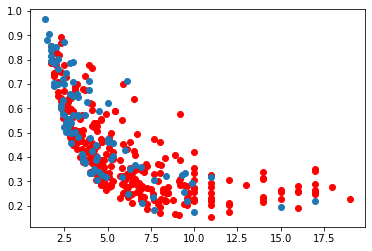

In [95]:
plt.scatter(odds_lost, proba_lost, color="r")
plt.scatter(odds_winned, proba_won)